# Кузьмичев Никита
## **Домашнее задание №6**

### Тема: деревья решений и ансамбли (bagging / random forest / boosting / stacking) и честный ML-эксперимент.

##### **1. Загрузка данных и первичный анализ**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.inspection import permutation_importance

# Создание структуры папок (п. 2.1)
os.makedirs('artifacts/figures', exist_ok=True)

# Загрузка данных (п. 2.3.1)
df = pd.read_csv('S06-hw-dataset-02.csv') # относительный путь

print("Первые 5 строк:")
print(df.head())
print("\nИнфо:")
print(df.info())
print("\nОписание:")
print(df.describe())
print("\nБаланс классов:")
print(df['target'].value_counts(normalize=True))

# Разделение на X и y
X = df.drop(['id', 'target'], axis=1) # id не используем
y = df['target']

Первые 5 строк:
   id       f01       f02       f03        f04       f05       f06       f07  \
0   1 -0.149235 -2.826966 -0.522901  -4.198449  1.364943  0.815043 -1.195518   
1   2 -1.966180 -4.877542  0.268367  -9.607791  0.097149  1.347185 -3.872575   
2   3 -0.555964 -0.999920  0.209673 -14.119498 -1.808950 -0.006222 -4.651108   
3   4 -2.049199 -5.600713 -1.664677  -6.263893 -5.224455  0.848351  1.407210   
4   5 -0.220556  4.889479 -2.235840   6.450046  0.774389 -2.382625  2.584816   

        f08       f09  ...       f29       f30       f31       f32       f33  \
0 -1.932232  2.396353  ... -0.159323  0.448015  0.572745  0.149916  0.878392   
1 -0.395117  1.710068  ... -0.389212  1.383794  0.169876  0.043969 -0.963545   
2  0.911944 -0.289037  ... -1.383970  3.044321 -0.182864  1.425649 -8.418598   
3 -0.542080  0.119102  ... -2.713080  2.762637 -0.520796 -0.142455  1.668338   
4  4.211856 -0.317889  ... -1.302872  2.478862  1.528610  1.098131  3.547087   

        f34        f35

##### **2. Train/Test-сплит и воспроизводимость**

In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Размер обучающей выборки X_train: ", X_train.shape)
print("Размер тестовой выборки X_test: ", X_test.shape)

Размер обучающей выборки X_train:  (14400, 37)
Размер тестовой выборки X_test:  (3600, 37)


##### **Заметка:**
##### Фиксированный seed и стратификация важны для воспроизводимости и сохранения пропорций классов в выборках

##### **3. Baseline’ы**

In [3]:
results_test = {}

# 1. Dummy Classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
results_test['Dummy'] = {
    'accuracy': accuracy_score(y_test, y_pred_dummy),
    'f1': f1_score(y_test, y_pred_dummy),
    'roc_auc': roc_auc_score(y_test, dummy.predict_proba(X_test)[:, 1])
}

# 2. Logistic Regression Pipeline
log_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42))
])
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
results_test['LogisticRegression'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'roc_auc': roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
}

In [4]:
print("\033[1m" + "Результаты" + "\033[0m")
print(f"Для Dummy Classifier: {results_test['Dummy']}")
print(f"Для Logistic Regression Pipeline: {results_test['LogisticRegression']}")

Результаты
Для Dummy Classifier: {'accuracy': 0.7375, 'f1': 0.0, 'roc_auc': np.float64(0.5)}
Для Logistic Regression Pipeline: {'accuracy': 0.8119444444444445, 'f1': 0.5606748864373783, 'roc_auc': np.float64(0.7976914875596609)}


##### **4. Модели недели 6**

In [5]:
search_summaries = {}

# Вспомогательная функция для CV
def run_search(model, params, name):
    grid = GridSearchCV(model, params, cv=3, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    search_summaries[name] = {
        'best_params': grid.best_params_,
        'best_cv_score': grid.best_score_
    }
    return grid.best_estimator_

# А) Decision Tree (контроль сложности)
dt_params = {'max_depth': [3, 5, 10], 'min_samples_leaf': [1, 10]}
best_dt = run_search(DecisionTreeClassifier(random_state=42), dt_params, 'DecisionTree')

# Б) Random Forest (случайный лесок)
rf_params = {'n_estimators': [50], 'max_depth': [5, 10], 'max_features': ['sqrt']}
best_rf = run_search(RandomForestClassifier(random_state=42), rf_params, 'RandomForest')

# В) Boosting (через HistGradientBoosting)
gb_params = {'learning_rate': [0.1], 'max_iter': [50, 100], 'max_depth': [3, 5]}
best_gb = run_search(HistGradientBoostingClassifier(random_state=42), gb_params, 'HistGradientBoosting')

In [6]:
models = {'DecisionTree': best_dt, 'RandomForest': best_rf, 'HistGradientBoosting': best_gb}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    results_test[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }

In [7]:
print("\033[1m" + "Результаты" + "\033[0m")
print(f"Для Decision Tree: {results_test['DecisionTree']}")
print(f"Для Random Forest: {results_test['RandomForest']}")
print(f"Для Boosting: {results_test['HistGradientBoosting']}")

Результаты
Для Decision Tree: {'accuracy': 0.8383333333333334, 'f1': 0.6576470588235294, 'roc_auc': np.float64(0.8371031995137457)}
Для Random Forest: {'accuracy': 0.8661111111111112, 'f1': 0.6845549738219895, 'roc_auc': np.float64(0.9139991430763558)}
Для Boosting: {'accuracy': 0.8991666666666667, 'f1': 0.7878433664523671, 'roc_auc': np.float64(0.9234276945764704)}


##### **5. Метрики качества**

In [8]:
# Сохранение артефактов
with open('artifacts/metrics_test.json', 'w') as f:
    json.dump(results_test, f)
with open('artifacts/search_summaries.json', 'w') as f:
    json.dump(search_summaries, f)

# Выбор лучшей модели (в этом случае по ROC-AUC)
best_model_name = max(results_test, key=lambda x: results_test[x]['roc_auc'])
joblib.dump(models[best_model_name], 'artifacts/best_model.joblib')

meta = {
    'best_model': best_model_name,
    'params': search_summaries.get(best_model_name, "N/A"),
    'test_metrics': results_test[best_model_name]
}
with open('artifacts/best_model_meta.json', 'w') as f:
    json.dump(meta, f)

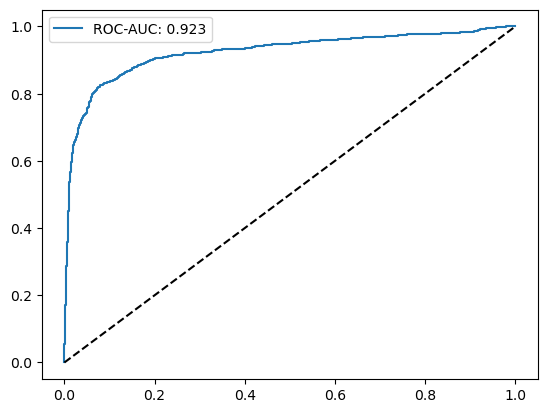

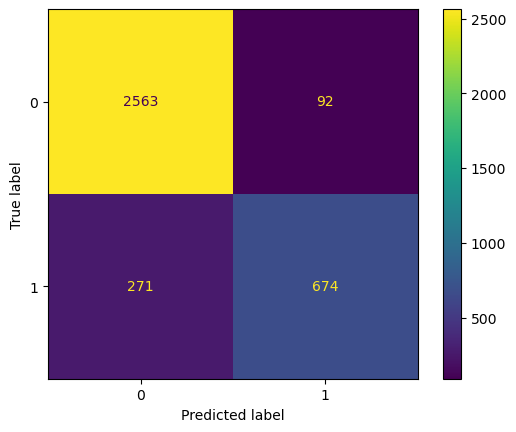

In [9]:
# Построение ROC-кривой для лучшей модели
best_clf = models[best_model_name]
fpr, tpr, _ = roc_curve(y_test, best_clf.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label=f'ROC-AUC: {results_test[best_model_name]["roc_auc"]:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.savefig('artifacts/figures/roc_curve.png') # [cite: 42]

# Confusion Matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
ConfusionMatrixDisplay(cm).plot()
plt.savefig('artifacts/figures/confusion_matrix.png')

##### **6. Интерпретация**

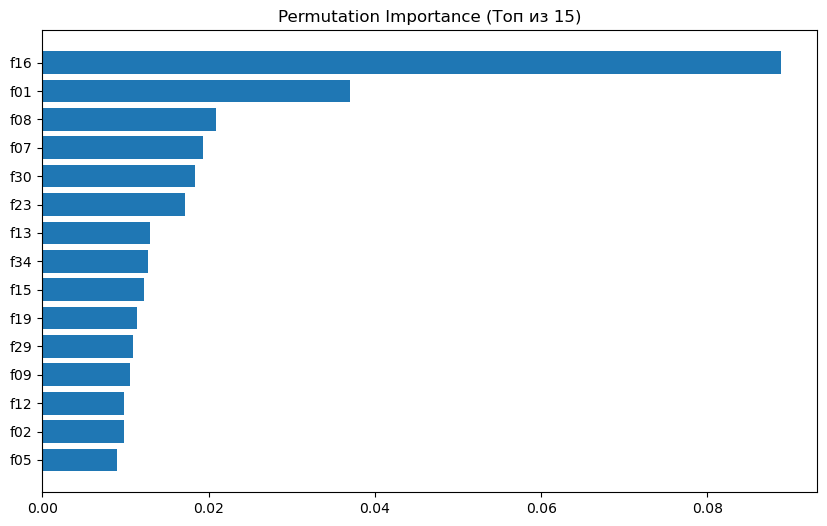

In [10]:
# Permutation Importance
perm_imp = permutation_importance(best_clf, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_imp.importances_mean.argsort()[-15:]
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_imp.importances_mean[sorted_idx])
plt.title("Permutation Importance (Топ из 15)")
plt.savefig('artifacts/figures/importance.png')